In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import librosa.feature as lf
import librosa as l
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.models import Model
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time


import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/manu/tank.csv', encoding = 'utf-8')

In [ ]:
df

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
0,2020-03-04 0:00,0,489,116,631,3.19,OK
1,2020-03-04 0:00,1,433,78,609,3.19,OK
2,2020-03-04 0:00,2,464,154,608,3.19,OK
3,2020-03-04 0:00,3,379,212,606,3.19,OK
4,2020-03-04 0:00,4,798,1736,604,3.21,OK
...,...,...,...,...,...,...,...
835195,2020-04-30 23:59,835195,755,1743,318,3.21,OK
835196,2020-04-30 23:59,835196,385,206,317,3.19,OK
835197,2020-04-30 23:59,835197,465,148,316,3.20,OK
835198,2020-04-30 23:59,835198,467,0,314,3.19,OK


In [ ]:
temp = df.iloc[:, 2:6]
temp

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP
0,489,116,631,3.19
1,433,78,609,3.19
2,464,154,608,3.19
3,379,212,606,3.19
4,798,1736,604,3.21
...,...,...,...,...
835195,755,1743,318,3.21
835196,385,206,317,3.19
835197,465,148,316,3.20
835198,467,0,314,3.19


In [ ]:
temp = temp.transpose()
temp

,0,1,2,3,4,5,6,7,8,9,...,835190,835191,835192,835193,835194,835195,835196,835197,835198,835199
MELT_TEMP,489.00,433.00,464.00,379.00,798.00,743.00,390.00,493.00,427.00,489.0,...,497.0,449.00,486.00,391.00,749.00,755.00,385.00,465.0,467.00,453.0
MOTORSPEED,116.00,78.00,154.00,212.00,1736.00,1722.00,212.00,152.00,0.00,148.0,...,141.0,80.00,159.00,213.00,1740.00,1743.00,206.00,148.0,0.00,125.0
MELT_WEIGHT,631.00,609.00,608.00,606.00,604.00,603.00,602.00,600.00,599.00,598.0,...,323.0,322.00,321.00,320.00,319.00,318.00,317.00,316.0,314.00,312.0
INSP,3.19,3.19,3.19,3.19,3.21,3.21,3.19,3.19,3.19,3.2,...,3.2,3.19,3.19,3.18,3.21,3.21,3.19,3.2,3.19,3.2


In [ ]:
hoho = pd.DataFrame([temp.iloc[0, 0:10]])

In [ ]:
hoho

,0,1,2,3,4,5,6,7,8,9
MELT_TEMP,489.0,433.0,464.0,379.0,798.0,743.0,390.0,493.0,427.0,489.0


In [ ]:
for i in range(len(df)//10) :
  if i == 0 :
    continue
  elif i == 1 :
    continue
  else :
    hoho.loc[i] = list(temp.iloc[0, 10*(i - 1) : 10*i])

In [ ]:
temp = hoho

from sklearn.preprocessing import StandardScaler

std = StandardScaler()
std.fit(temp)
temp = std.transform(temp)

In [ ]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
import numpy as np
import seaborn as sns
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

leaky_relu = tf.nn.leaky_relu

d_input = temp.shape[1]
d_hidden = 256
d_output = 1
g_input = 10
g_hidden = 256
g_output = d_input

def makeZ(m, n) :
  z = np.random.uniform(-1.0, 1.0, size = [m, n])
  return z

def myOptimizer(lr) :
  return RMSprop(learning_rate = lr)

def build_D() :
  d_x = Input(batch_shape = (None, d_input))
  d_h1 = Dense(d_hidden, activation = leaky_relu)(d_x)
  d_h2 = Dense(d_hidden/2, activation = leaky_relu)(d_h1)
  d_h3 = Dense(d_hidden/4, activation = leaky_relu)(d_h2)
  d_h4 = Dense(d_hidden/8, activation = leaky_relu)(d_h3)
  d_o = Dense(d_output, activation = 'sigmoid')(d_h4)

  d_model = Model(d_x, d_o)
  d_model.compile(loss = 'binary_crossentropy', optimizer = myOptimizer(0.001))

  return d_model

def build_G() :
  g_x = Input(batch_shape = (None, g_input))
  g_h1 = Dense(g_hidden, activation = leaky_relu)(g_x)
  g_h2 = Dense(g_hidden/2, activation = leaky_relu)(g_h1)
  g_h3 = Dense(g_hidden/4, activation = leaky_relu)(g_h2)
  g_h4 = Dense(g_hidden/8, activation = leaky_relu)(g_h3)
  g_o = Dense(g_output, activation = 'linear')(g_h4)

  g_model = Model(g_x, g_o)

  return g_model

def build_GAN(discriminator, generator) :
  discriminator.trainable = False
  z = Input(batch_shape = (None, g_input))
  Gz = generator(z)
  DGz = discriminator(Gz)

  gan_model = Model(z, DGz)
  gan_model.compile(loss = 'binary_crossentropy', optimizer = myOptimizer(0.001))

  return gan_model

K.clear_session()
D = build_D()
G = build_G()
GAN = build_GAN(D, G)

n_batch_cnt = 6
n_batch_size = int(temp.shape[0] / n_batch_cnt)
EPOCHS = 100

for epoch in range(EPOCHS) :
  for n in range(n_batch_cnt) :
    from_, to_ = n*n_batch_size, (n+1)*n_batch_size
    if n == n_batch_cnt - 1 :
      to_ = temp.shape[0]

    X_batch = temp[from_: to_]
    Z_batch = makeZ(m = X_batch.shape[0], n = g_input)
    Gz = G.predict(Z_batch)

    d_target = np.zeros(X_batch.shape[0]*2)
    d_target[:X_batch.shape[0]] = 0.9
    d_target[X_batch.shape[0]:] = 0.1
    bX_Gz = np.concatenate([X_batch, Gz])

    g_target = np.zeros(Z_batch.shape[0])
    g_target[:] = 0.9

    loss_D = D.train_on_batch(bX_Gz, d_target)

    loss_G = GAN.train_on_batch(Z_batch, g_target)

  if epoch % 10 == 0 :
    z = makeZ(m = temp.shape[0], n = g_input)
    print("Epoch: %d, D-loss = %.4f, G-loss = %.4f" %(epoch, loss_D, loss_G))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Epoch: 0, D-loss = 0.5973, G-loss = 0.6918
Epoch: 10, D-loss = 0.6861, G-loss = 1.1091
Epoch: 20, D-loss = 0.6755, G-loss = 0.7684
Epoch: 30, D-loss = 0.6991, G-loss = 0.7175
Epoch: 40, D-loss = 0.6917, G-loss = 0.7098
Epoch: 50, D-loss = 0.6911, G-loss = 0.7040
Epoch: 60, D-loss = 0.6890, G-loss = 0.7092
Epoch: 70, D-loss = 0.6873, G-loss = 0.7048
Epoch: 80, D-loss = 0.6890, G-loss = 0.7029
Epoch: 90, D-loss = 0.6895, G-loss = 0.7031


In [ ]:
z = makeZ(m = temp.shape[0], n = g_input)
fake_data = G.predict(z)

fake_data = std.inverse_transform(fake_data)
fake_data_df_ok = pd.DataFrame(fake_data)
fake_data_df_ok

,0,1,2,3,4,5,6,7,8,9
0,448.951630,481.444214,468.541412,411.850677,745.944702,758.411133,396.086884,498.313568,428.056213,482.153992
1,449.870300,460.931915,484.971344,385.364624,767.619263,745.262817,372.532379,470.881104,462.555817,471.995972
2,435.577148,465.326965,450.452881,399.973022,746.402954,766.014893,401.884827,497.524872,421.529510,478.462128
3,485.210419,436.173523,501.647888,399.962677,735.950928,750.003235,424.133270,492.842834,443.858459,470.084015
4,444.192078,462.640198,457.662659,407.663116,743.039856,743.594482,395.661804,464.436829,462.903809,490.925110
...,...,...,...,...,...,...,...,...,...,...
83514,496.693085,434.564362,473.770264,396.757202,756.800354,751.878174,383.589508,470.370605,422.615265,500.162079
83515,452.844421,463.475891,477.284607,391.233124,756.809998,762.965027,383.470490,467.286346,456.613251,461.835083
83516,481.174622,460.090668,486.250244,407.762024,731.632568,755.638733,428.703735,482.443756,442.695984,475.002655
83517,481.068573,460.507202,488.429810,395.162354,773.832886,720.430298,383.231750,479.378510,449.655701,476.855927


In [ ]:
hoho

,0,1,2,3,4,5,6,7,8,9
MELT_TEMP,489.0,433.0,464.0,379.0,798.0,743.0,390.0,493.0,427.0,489.0
1,489.0,433.0,464.0,379.0,798.0,743.0,390.0,493.0,427.0,489.0
2,507.0,408.0,474.0,358.0,740.0,772.0,424.0,460.0,440.0,504.0
3,474.0,446.0,487.0,393.0,740.0,761.0,383.0,483.0,435.0,456.0
4,437.0,435.0,449.0,364.0,759.0,749.0,389.0,468.0,451.0,461.0
...,...,...,...,...,...,...,...,...,...,...
18865,484.0,413.0,486.0,381.0,753.0,702.0,379.0,476.0,429.0,537.0
18866,486.0,445.0,477.0,380.0,730.0,767.0,412.0,496.0,431.0,490.0
18867,505.0,453.0,479.0,426.0,758.0,739.0,395.0,467.0,459.0,473.0
18868,484.0,451.0,468.0,360.0,750.0,760.0,386.0,443.0,472.0,482.0


#

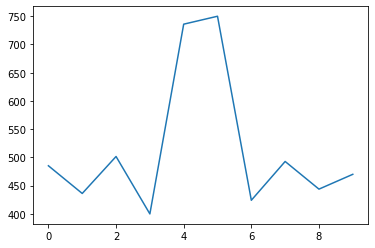

In [ ]:
plt.plot(fake_data_df_ok.loc[3])

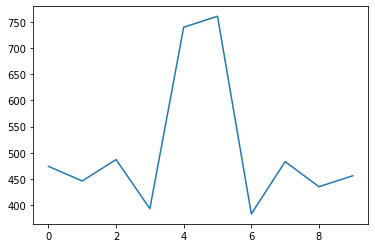

In [ ]:
plt.plot(hoho.loc[3])

#motorspeed

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/manu/tank.csv', encoding = 'utf-8')

In [ ]:
temp = df.iloc[:, 2:6]
temp = temp.transpose()
temp

,0,1,2,3,4,5,6,7,8,9,...,835190,835191,835192,835193,835194,835195,835196,835197,835198,835199
MELT_TEMP,489.00,433.00,464.00,379.00,798.00,743.00,390.00,493.00,427.00,489.0,...,497.0,449.00,486.00,391.00,749.00,755.00,385.00,465.0,467.00,453.0
MOTORSPEED,116.00,78.00,154.00,212.00,1736.00,1722.00,212.00,152.00,0.00,148.0,...,141.0,80.00,159.00,213.00,1740.00,1743.00,206.00,148.0,0.00,125.0
MELT_WEIGHT,631.00,609.00,608.00,606.00,604.00,603.00,602.00,600.00,599.00,598.0,...,323.0,322.00,321.00,320.00,319.00,318.00,317.00,316.0,314.00,312.0
INSP,3.19,3.19,3.19,3.19,3.21,3.21,3.19,3.19,3.19,3.2,...,3.2,3.19,3.19,3.18,3.21,3.21,3.19,3.2,3.19,3.2


In [ ]:
hoho2 = pd.DataFrame([temp.iloc[1, 0:10]])
hoho2

,0,1,2,3,4,5,6,7,8,9
MOTORSPEED,116.0,78.0,154.0,212.0,1736.0,1722.0,212.0,152.0,0.0,148.0


In [ ]:
for i in range(len(df)//10) :
  if i == 0 :
    continue
  elif i == 1 :
    continue
  else :
    hoho2.loc[i] = list(temp.iloc[1, 10*(i - 1) : 10*i])

In [ ]:
hoho2

,0,1,2,3,4,5,6,7,8,9
MOTORSPEED,116.0,78.0,154.0,212.0,1736.0,1722.0,212.0,152.0,0.0,148.0
2,128.0,66.0,138.0,201.0,1740.0,1729.0,195.0,158.0,0.0,133.0
3,135.0,67.0,161.0,205.0,1748.0,1721.0,200.0,167.0,90.0,111.0
4,129.0,0.0,145.0,232.0,1718.0,1737.0,222.0,163.0,0.0,94.0
5,145.0,72.0,167.0,197.0,1737.0,1748.0,203.0,157.0,111.0,100.0
...,...,...,...,...,...,...,...,...,...,...
83515,102.0,69.0,162.0,214.0,1751.0,1736.0,204.0,180.0,56.0,149.0
83516,136.0,74.0,170.0,230.0,1748.0,1746.0,204.0,162.0,0.0,127.0
83517,103.0,0.0,163.0,185.0,1725.0,1707.0,198.0,166.0,85.0,135.0
83518,108.0,73.0,168.0,207.0,1737.0,1723.0,189.0,132.0,0.0,116.0


In [ ]:
temp = hoho2

from sklearn.preprocessing import StandardScaler

std = StandardScaler()
std.fit(temp)
temp = std.transform(temp)

In [ ]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
import numpy as np
import seaborn as sns
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

leaky_relu = tf.nn.leaky_relu

d_input = temp.shape[1]
d_hidden = 256
d_output = 1
g_input = 10
g_hidden = 256
g_output = d_input

def makeZ(m, n) :
  z = np.random.uniform(-1.0, 1.0, size = [m, n])
  return z

def myOptimizer(lr) :
  return RMSprop(learning_rate = lr)

def build_D() :
  d_x = Input(batch_shape = (None, d_input))
  d_h1 = Dense(d_hidden, activation = leaky_relu)(d_x)
  d_h2 = Dense(d_hidden/2, activation = leaky_relu)(d_h1)
  d_h3 = Dense(d_hidden/4, activation = leaky_relu)(d_h2)
  d_h4 = Dense(d_hidden/8, activation = leaky_relu)(d_h3)
  d_o = Dense(d_output, activation = 'sigmoid')(d_h4)

  d_model = Model(d_x, d_o)
  d_model.compile(loss = 'binary_crossentropy', optimizer = myOptimizer(0.001))

  return d_model

def build_G() :
  g_x = Input(batch_shape = (None, g_input))
  g_h1 = Dense(g_hidden, activation = leaky_relu)(g_x)
  g_h2 = Dense(g_hidden/2, activation = leaky_relu)(g_h1)
  g_h3 = Dense(g_hidden/4, activation = leaky_relu)(g_h2)
  g_h4 = Dense(g_hidden/8, activation = leaky_relu)(g_h3)
  g_o = Dense(g_output, activation = 'linear')(g_h4)

  g_model = Model(g_x, g_o)

  return g_model

def build_GAN(discriminator, generator) :
  discriminator.trainable = False
  z = Input(batch_shape = (None, g_input))
  Gz = generator(z)
  DGz = discriminator(Gz)

  gan_model = Model(z, DGz)
  gan_model.compile(loss = 'binary_crossentropy', optimizer = myOptimizer(0.001))

  return gan_model

K.clear_session()
D = build_D()
G = build_G()
GAN = build_GAN(D, G)

n_batch_cnt = 6
n_batch_size = int(temp.shape[0] / n_batch_cnt)
EPOCHS = 100

for epoch in range(EPOCHS) :
  for n in range(n_batch_cnt) :
    from_, to_ = n*n_batch_size, (n+1)*n_batch_size
    if n == n_batch_cnt - 1 :
      to_ = temp.shape[0]

    X_batch = temp[from_: to_]
    Z_batch = makeZ(m = X_batch.shape[0], n = g_input)
    Gz = G.predict(Z_batch)

    d_target = np.zeros(X_batch.shape[0]*2)
    d_target[:X_batch.shape[0]] = 0.9
    d_target[X_batch.shape[0]:] = 0.1
    bX_Gz = np.concatenate([X_batch, Gz])

    g_target = np.zeros(Z_batch.shape[0])
    g_target[:] = 0.9

    loss_D = D.train_on_batch(bX_Gz, d_target)

    loss_G = GAN.train_on_batch(Z_batch, g_target)

  if epoch % 10 == 0 :
    z = makeZ(m = temp.shape[0], n = g_input)
    print("Epoch: %d, D-loss = %.4f, G-loss = %.4f" %(epoch, loss_D, loss_G))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Epoch: 0, D-loss = 0.5754, G-loss = 0.6949
Epoch: 10, D-loss = 0.6447, G-loss = 1.1010
Epoch: 20, D-loss = 0.6977, G-loss = 0.7503
Epoch: 30, D-loss = 0.6561, G-loss = 0.7908
Epoch: 40, D-loss = 0.6838, G-loss = 0.7408
Epoch: 50, D-loss = 0.6818, G-loss = 0.7307
Epoch: 60, D-loss = 0.6810, G-loss = 0.8569
Epoch: 70, D-loss = 0.6494, G-loss = 0.7412
Epoch: 80, D-loss = 0.6498, G-loss = 0.9167
Epoch: 90, D-loss = 0.6238, G-loss = 0.7905


In [ ]:
z = makeZ(m = temp.shape[0], n = g_input)
fake_data = G.predict(z)

fake_data = std.inverse_transform(fake_data)
fake_data_df_ok2 = pd.DataFrame(fake_data)
fake_data_df_ok2

,0,1,2,3,4,5,6,7,8,9
0,112.958015,71.125412,164.392395,200.815842,1757.681274,1774.169067,201.581451,172.640228,80.689926,109.864174
1,158.290329,99.656731,157.481674,205.006180,1740.816284,1739.899658,205.063660,177.711395,67.244751,139.989136
2,127.092880,66.245384,158.882339,242.572525,1721.101196,1718.754150,212.659363,156.763962,68.515343,129.166061
3,151.127151,82.728012,170.639313,217.759552,1735.231567,1708.283569,216.821579,157.941299,75.411102,114.537376
4,149.612259,59.699284,179.013428,232.780487,1764.462891,1731.755249,194.857056,176.457855,83.224007,132.486557
...,...,...,...,...,...,...,...,...,...,...
83514,122.235321,76.294479,177.164261,209.771759,1723.565430,1733.084473,224.904633,197.800034,65.403809,149.049683
83515,99.352028,68.297478,178.478470,213.788818,1740.600586,1768.145996,204.791992,174.110413,66.044472,126.379265
83516,128.953934,65.137642,176.797806,210.132034,1734.289673,1716.358154,204.070572,203.333878,66.189102,140.712128
83517,122.379295,67.280151,174.003860,223.413834,1741.965332,1723.516357,212.999832,142.576767,68.425407,120.740997


In [ ]:
tbob = np.ravel(fake_data_df_ok.values)
tbob2 = np.ravel(fake_data_df_ok2.values)

In [ ]:
fake_df = pd.DataFrame()
fake_df['MT'] = tbob
fake_df['MS'] = tbob2
fake_df

,MT,MS
0,448.951630,112.958015
1,481.444214,71.125412
2,468.541412,164.392395
3,411.850677,200.815842
4,745.944702,1757.681274
...,...,...
835185,748.858643,1723.523438
835186,395.066650,177.315323
835187,477.024811,132.616211
835188,442.728241,36.206280


In [ ]:
fake_df.to_csv('/content/drive/MyDrive/manu/fake_df.csv', encoding = 'utf-8')

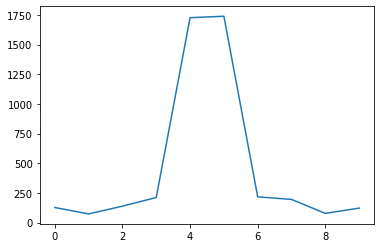

In [ ]:
plt.plot(fake_data_df_ok2.loc[2])

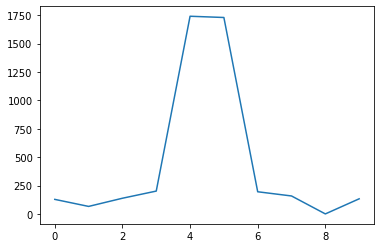

In [ ]:
plt.plot(hoho2.loc[2])

# lstmgan 만들어보기

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/manu/tank.csv', encoding = 'utf-8')

In [ ]:
temp = df.iloc[:188700, 2:6]
temp

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP
0,489,116,631,3.19
1,433,78,609,3.19
2,464,154,608,3.19
3,379,212,606,3.19
4,798,1736,604,3.21
...,...,...,...,...
188695,766,1722,264,3.21
188696,384,220,263,3.19
188697,492,170,260,3.19
188698,396,77,259,3.19


In [ ]:
temp = temp.transpose()
temp

,0,1,2,3,4,5,6,7,8,9,...,188690,188691,188692,188693,188694,188695,188696,188697,188698,188699
MELT_TEMP,489.00,433.00,464.00,379.00,798.00,743.00,390.00,493.00,427.00,489.0,...,444.00,406.00,485.00,364.00,726.00,766.00,384.00,492.00,396.00,452.0
MOTORSPEED,116.00,78.00,154.00,212.00,1736.00,1722.00,212.00,152.00,0.00,148.0,...,125.00,74.00,142.00,209.00,1735.00,1722.00,220.00,170.00,77.00,138.0
MELT_WEIGHT,631.00,609.00,608.00,606.00,604.00,603.00,602.00,600.00,599.00,598.0,...,271.00,270.00,269.00,267.00,265.00,264.00,263.00,260.00,259.00,257.0
INSP,3.19,3.19,3.19,3.19,3.21,3.21,3.19,3.19,3.19,3.2,...,3.19,3.19,3.19,3.19,3.22,3.21,3.19,3.19,3.19,3.2


In [ ]:
hoho = pd.DataFrame([temp.iloc[0, 0:10]])

In [ ]:
hoho

,0,1,2,3,4,5,6,7,8,9
MELT_TEMP,489.0,433.0,464.0,379.0,798.0,743.0,390.0,493.0,427.0,489.0


In [ ]:
for i in range(18870) :
  if i == 0 :
    continue
  elif i == 1 :
    continue
  else :
    hoho.loc[i] = list(temp.iloc[0, 10*(i - 1) : 10*i])

In [ ]:
hoho

,0,1,2,3,4,5,6,7,8,9
MELT_TEMP,489.0,433.0,464.0,379.0,798.0,743.0,390.0,493.0,427.0,489.0
2,507.0,408.0,474.0,358.0,740.0,772.0,424.0,460.0,440.0,504.0
3,474.0,446.0,487.0,393.0,740.0,761.0,383.0,483.0,435.0,456.0
4,437.0,435.0,449.0,364.0,759.0,749.0,389.0,468.0,451.0,461.0
5,450.0,435.0,459.0,392.0,757.0,749.0,402.0,463.0,432.0,501.0
...,...,...,...,...,...,...,...,...,...,...
18865,484.0,413.0,486.0,381.0,753.0,702.0,379.0,476.0,429.0,537.0
18866,486.0,445.0,477.0,380.0,730.0,767.0,412.0,496.0,431.0,490.0
18867,505.0,453.0,479.0,426.0,758.0,739.0,395.0,467.0,459.0,473.0
18868,484.0,451.0,468.0,360.0,750.0,760.0,386.0,443.0,472.0,482.0


In [ ]:
hoho.shape

(18869, 10)

In [ ]:
def make_dataset(data, window_size) :
  feature_list = []
  for i in range(len(data) - window_size) :
    feature_list.append(np.array(data.iloc[i : i+window_size]))
  return np.array(feature_list)

In [ ]:
haha = make_dataset(hoho, 10)
haha

array([[[489., 433., 464., ..., 493., 427., 489.],
        [507., 408., 474., ..., 460., 440., 504.],
        [474., 446., 487., ..., 483., 435., 456.],
        ...,
        [469., 428., 470., ..., 479., 469., 490.],
        [509., 450., 509., ..., 481., 457., 460.],
        [503., 461., 467., ..., 485., 435., 486.]],

       [[507., 408., 474., ..., 460., 440., 504.],
        [474., 446., 487., ..., 483., 435., 456.],
        [437., 435., 449., ..., 468., 451., 461.],
        ...,
        [509., 450., 509., ..., 481., 457., 460.],
        [503., 461., 467., ..., 485., 435., 486.],
        [468., 417., 478., ..., 504., 457., 466.]],

       [[474., 446., 487., ..., 483., 435., 456.],
        [437., 435., 449., ..., 468., 451., 461.],
        [450., 435., 459., ..., 463., 432., 501.],
        ...,
        [503., 461., 467., ..., 485., 435., 486.],
        [468., 417., 478., ..., 504., 457., 466.],
        [509., 436., 486., ..., 493., 476., 521.]],

       ...,

       [[489., 417., 476

In [ ]:
haha.shape

(18859, 10, 10)

In [ ]:
temp = haha

In [ ]:
tf.compat.v1.experimental.output_all_intermediates(True)

In [ ]:
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
import numpy as np
import seaborn as sns
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

leaky_relu = tf.nn.leaky_relu

d_input = temp.shape[1]
d_hidden = 256
d_output = 1
g_input = 10
g_hidden = 256
g_output = d_input

def makeZ(m, k, n) :
  z = np.random.uniform(-1.0, 1.0, size = [m, k, n])
  return z

def myOptimizer(lr) :
  return RMSprop(learning_rate = lr)

def build_D() :
  d_x = Input(shape = (haha.shape[1], haha.shape[2]))
  d_h1 = Dense(d_hidden, activation = leaky_relu)(d_x)
  d_h2 = Dense(d_hidden/2, activation = leaky_relu)(d_h1)
  d_h3 = Dense(d_hidden/4, activation = leaky_relu)(d_h2)
  d_h4 = Dense(d_hidden/8, activation = leaky_relu)(d_h3)
  d_o = Dense(d_output, activation = 'sigmoid')(d_h4)

  d_model = Model(d_x, d_o)
  d_model.compile(loss = 'binary_crossentropy', optimizer = myOptimizer(0.001))

  return d_model

def build_G() :
  g_x = Input(shape = (haha.shape[1], haha.shape[2]))
  g_h1 = LSTM(int(g_hidden/2), activation = leaky_relu, return_sequences=True)(g_x)
  g_h2 = LSTM(int(g_hidden/4), activation = leaky_relu, return_sequences=True)(g_h1)
  g_h3 = LSTM(int(g_hidden/4), activation = leaky_relu, return_sequences=True)(g_h2)
  g_h4 = LSTM(int(g_hidden/8), activation = leaky_relu, return_sequences=True)(g_h3)
  g_o = Dense(g_output, activation = 'linear')(g_h4)

  g_model = Model(g_x, g_o)

  return g_model

def build_GAN(discriminator, generator) :
  discriminator.trainable = False
  z = Input(shape = (haha.shape[1], haha.shape[2]))
  Gz = generator(z)
  DGz = discriminator(Gz)

  gan_model = Model(z, DGz)
  gan_model.compile(loss = 'binary_crossentropy', optimizer = myOptimizer(0.001))

  return gan_model

K.clear_session()
D = build_D()
G = build_G()
GAN = build_GAN(D, G)

n_batch_cnt = 6
n_batch_size = int(temp.shape[0] / n_batch_cnt)
EPOCHS = 100

for epoch in range(EPOCHS) :
  for n in range(n_batch_cnt) :
    from_, to_ = n*n_batch_size, (n+1)*n_batch_size
    if n == n_batch_cnt - 1 :
      to_ = temp.shape[0]

    X_batch = temp[from_: to_]
    Z_batch = makeZ(m = X_batch.shape[0], k = X_batch.shape[1], n = g_input)
    Gz = G.predict(Z_batch)

    tbob = []
    tbob3 = []
    for i in range(10) :
      tbob3.append(list(np.zeros(1)))

    for i in range(X_batch.shape[0]*2) :
      tbob.append(tbob3)
    d_target = np.array(tbob)
    d_target[:X_batch.shape[0]] = 0.9
    d_target[X_batch.shape[0]:] = 0.1
    bX_Gz = np.concatenate([X_batch, Gz])


    tbob4 = []
    tbob5 = []
    for i in range(10) :
      tbob5.append(list(np.zeros(1)))

    for i in range(Z_batch.shape[0]) :
      tbob4.append(tbob5)
    g_target = np.array(tbob4)
    # g_target = np.zeros(Z_batch.shape[0])
    g_target[:] = 0.9

    loss_D = D.train_on_batch(bX_Gz, d_target)

    loss_G = GAN.train_on_batch(Z_batch, g_target)

  if epoch % 10 == 0 :
    z = makeZ(m = temp.shape[0], k = temp.shape[1], n = g_input)
    print("Epoch: %d, D-loss = %.4f, G-loss = %.4f" %(epoch, loss_D, loss_G))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Epoch: 0, D-loss = 9.6750, G-loss = 0.7286
Epoch: 10, D-loss = 3.4164, G-loss = 0.8245
Epoch: 20, D-loss = 1.6686, G-loss = 0.8755
Epoch: 30, D-loss = 0.6666, G-loss = 3.0706
Epoch: 40, D-loss = 3.3305, G-loss = 1.2552
Epoch: 50, D-loss = 0.5997, G-loss = 0.8455
Epoch: 60, D-loss = 1.0434, G-loss = 14.8114
Epoch: 70, D-loss = 0.8579, G-loss = 1.0006
Epoch: 80, D-loss = 0.6049, G-loss = 0.8272
Epoch: 90, D-loss = 0.5705, G-loss = 1.5262


In [ ]:
z = makeZ(m = temp.shape[0], k = temp.shape[1], n = g_input)
fake_data = G.predict(z)
fake_data
# fake_data = std.inverse_transform(fake_data)
# fake_data_df_ok2 = pd.DataFrame(fake_data)
# fake_data_df_ok2

array([[[  15.948375 ,   13.855223 ,   15.779724 , ...,   14.319668 ,
           15.1317625,   15.087493 ],
        [  65.663345 ,   58.181427 ,   59.256126 , ...,   56.269108 ,
           56.347336 ,   59.329193 ],
        [  94.59287  ,   82.124245 ,   91.621925 , ...,   88.47939  ,
           77.71705  ,   81.71399  ],
        ...,
        [ 505.3793   ,  411.96658  ,  473.64658  , ...,  406.9573   ,
          444.82098  ,  474.6276   ],
        [ 710.1444   ,  566.49316  ,  670.0064   , ...,  561.58374  ,
          611.1555   ,  648.6449   ],
        [1000.9628   ,  777.8649   ,  949.1032   , ...,  778.68555  ,
          835.2652   ,  884.0733   ]],

       [[  10.740683 ,    9.277538 ,   10.744972 , ...,    9.722241 ,
           10.336651 ,   10.063015 ],
        [  57.214428 ,   49.601624 ,   51.251064 , ...,   48.51852  ,
           49.96789  ,   51.96592  ],
        [  81.49654  ,   72.38618  ,   81.23007  , ...,   77.64383  ,
           67.92612  ,   71.8075   ],
        ...,
